In [340]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import yaml
import zipfile

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rcParams

from chspy import CubicHermiteSpline

# os.chdir(Path(os.getcwd()).parent)
import sys
from pathlib import Path
current_dir = Path().resolve()
sys.path.append(str(current_dir.parent))

from assistive_arm.utils.data_preprocessing import prepare_opencap_markers, smooth_dataframe, interpolate_dataframe
from assistive_arm.utils.data_preprocessing import zero_after_nth_crossing, interpolate_to_zero_start, isolate_central_peak, butterworth_low_pass, isolate_central_peak_bis
from assistive_arm.utils.optimum_length_utils import compute_torque_profiles, get_rotation_matrix, check_theta
from assistive_arm.utils.plotting import create_torque_plot


### Load Datas

##### Simulation Data

In [341]:
assist_only_y = False
assist_scalex_scaley = False

In [342]:
# Session paramaters
subject = "CG" # CG / ZK
task = "sts" # sts / reaching / stairs
assistance = "no_arm" # no_arm / assistive_arm_off / assistive_arm_on
trial_ID = "1"
#assistive_force = None  # 700N or None ?? or 100N??
model_type = "simple" # simple / full
date = "20240503"

# Session datas
#session = Path(f"/Users/camilleguillaume/Documents/MasterThesis/Opencap_data/{date}_opencap_{task}_{subject}")
trial_name = f"{task}_{assistance}_{trial_ID}"
session = Path(f"/Users/camilleguillaume/Documents/MasterThesis/Opencap_data/{date}_opencap_{task}_{subject}")
kinematics_path = str(session / "OpenSimData" / "Kinematics" / f"{trial_name}.mot")
markers_path = str(session / "MarkerData" / f"{trial_name}.trc")

# Solution datas
solutions_path = Path(f"/Users/camilleguillaume/Documents/MasterThesis/assistive-arm/moco/control_solutions/{trial_name}")
#solutions_path = Path(f"../moco/control_solutions/{trial_name}")
print(solutions_path)

assist_false = True
ground_forces_estimated_false = True
assist_false_pelvis_assist = True

if assist_false:
    date_simulation="2024-08-20"
    time_simulation="17-07"
    solution_assist_false = solutions_path / f"{subject}_{model_type}_{task}_{assistance}_{trial_ID}_assistance_none_{date_simulation}_{time_simulation}.sto"
    if ground_forces_estimated_false: 
        grf_osim_feet_false = solutions_path / f"{subject}_{model_type}_{task}_{assistance}_{trial_ID}_assistance_none_{date_simulation}_{time_simulation}_grfs_osim_feet.sto" 
        grf_osim_chair_false = solutions_path / f"{subject}_{model_type}_{task}_{assistance}_{trial_ID}_assistance_none_{date_simulation}_{time_simulation}_grfs_osim_chair.sto" 

if assist_false_pelvis_assist:
    date_simulation="2024-07-30"
    time_simulation="16-28"
    solution_assist_false_before = solutions_path / f"{subject}_{model_type}_{task}_{assistance}_{trial_ID}_assistance_none_{date_simulation}_{time_simulation}.sto"
    if ground_forces_estimated_false: 
        grf_osim_feet_false_before = solutions_path / f"{subject}_{model_type}_{task}_{assistance}_{trial_ID}_assistance_none_{date_simulation}_{time_simulation}_grfs_osim_feet.sto" 
        grf_osim_chair_false_before = solutions_path / f"{subject}_{model_type}_{task}_{assistance}_{trial_ID}_assistance_none_{date_simulation}_{time_simulation}_grfs_osim_chair.sto" 
    

/Users/camilleguillaume/Documents/MasterThesis/assistive-arm/moco/control_solutions/sts_no_arm_1


In [343]:
def read_sto_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Find the index of the 'endheader' line
    header_end = next(i for i, line in enumerate(lines) if line.strip() == 'endheader')
    
    # The next line after 'endheader' contains the column names
    column_names = lines[header_end + 1].strip().split('\t')
    
    # Read the data, starting from the line after the column names
    df = pd.read_csv(file_path, 
                     delimiter='\t', 
                     skiprows=header_end + 2,  # Skip header + column names row
                     names=column_names)  # Use the extracted column names
    
    return df

# Assisted case
#Store solutions sto files into dataframes
if assist_false:
    df_assist_false = pd.read_csv(solution_assist_false, delimiter="\t", skiprows=18)
    config_path_false = solutions_path / f"{solution_assist_false.stem}.yaml"
    with open(config_path_false, 'r') as f:
        config_file_false = yaml.load(f, Loader=yaml.FullLoader)
    print(yaml.dump(config_file_false, indent=4, sort_keys=False))

#Store grfs files into dataframes
if assist_false and ground_forces_estimated_false:
    df_grf_osim_feet_false = read_sto_file(grf_osim_feet_false)
    df_grf_osim_chair_false = read_sto_file(grf_osim_chair_false)

# Unassisted case
#Store solutions sto files into dataframes
if assist_false_pelvis_assist:
    df_assist_false_before = pd.read_csv(solution_assist_false_before, delimiter="\t", skiprows=18)
    config_path_false_before = solutions_path / f"{solution_assist_false_before.stem}.yaml"
    with open(config_path_false_before, 'r') as f:
        config_file_false_before = yaml.load(f, Loader=yaml.FullLoader)
    print(yaml.dump(config_file_false_before, indent=4, sort_keys=False))

#Store grfs files into dataframes
if assist_false and ground_forces_estimated_false:
    df_grf_osim_feet_false_before = read_sto_file(grf_osim_feet_false_before)
    df_grf_osim_chair_false_before = read_sto_file(grf_osim_chair_false_before)

    config_file_false_before["tuning_test"]=False

actuator_magnitude: 10
add_mocap_GRF: false
add_osim_GRF: true
add_osim_GRF_precomputed: false
assistive_force: null
control_effort_muscles: 20
control_effort_weight: 0.001
coord_actuator_opt_value: 250
ground_forces: false
mesh_interval: 0.05
min_actuators: false
minimal_actuators: false
osim_GRF_type: s8
pelvis_ty_positive: true
reserve_feet_weight: 1
reserve_hip_weight: 5
reserve_knee_weight: 5
reserve_pelvis_opt_value: 700
reserve_pelvis_weight: 15
reserve_pelvis_weight_txy: 0
solution_name: CG_simple_sts_no_arm_1_assistance_none_2024-08-20_17-07
solution_path: /Users/camilleguillaume/Documents/MasterThesis/Opencap_data/20240503_opencap_sts_CG/control_solutions/sts_no_arm_1/CG_simple_sts_no_arm_1_assistance_none_2024-08-20_17-07.sto
subject: CG
t_0: 3.8
t_f: 6
target_path: /Users/camilleguillaume/Documents/MasterThesis/Opencap_data/20240503_opencap_sts_CG/OpenSimData/Model
tracking_weight: 1
tracking_weight_pelvis_txy: 1
trial_kinematics_path: /Users/camilleguillaume/Documents/Mast

#### Read marker datas

In [344]:
# Ground truth from opencap
df_kinematics = read_sto_file(kinematics_path)
opencap_markers = pd.read_csv(markers_path, delimiter="\t", skiprows=3).tail(-1)
filtered_markers = prepare_opencap_markers(opencap_markers)

# Simulation without assistance
if assist_false_pelvis_assist:
    df = df_assist_false_before.copy()
    joints = []
    for column in df.columns:
        if "forceset" not in column:
            if "speed" not in column:
                if ("pelvis" in column) or ("lumbar" in column) or ("_r" in column) or ("_l" in column):
                    joints.append(column)

    df_joints_false_before= df[joints]
    df_joints_false_before.columns = [column.split("/")[3] for column in df_joints_false_before.columns]
    df_joints_false_before["time"]=df.time

# Simulation with assistance 
if assist_false:
    df = df_assist_false.copy()
    joints = []
    for column in df.columns:
        if "forceset" not in column:
            if "speed" not in column:
                if ("pelvis" in column) or ("lumbar" in column) or ("_r" in column) or ("_l" in column):
                    joints.append(column)

    df_joints_false= df[joints]
    df_joints_false.columns = [column.split("/")[3] for column in df_joints_false.columns]
    df_joints_false["time"]=df.time

/var/folders/3w/gl1bd25n1q78tgfp6jspsxb00000gn/T/ipykernel_9107/523809781.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joints_false_before["time"]=df.time
/var/folders/3w/gl1bd25n1q78tgfp6jspsxb00000gn/T/ipykernel_9107/523809781.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joints_false["time"]=df.time


In [345]:
df_simulation_before = df_joints_false_before.copy()
df_simulation = df_joints_false.copy()

# Align time ranges
df_ground_truth_aligned = df_kinematics[
    (df_kinematics['time'] >= df_simulation['time'].min()) &
    (df_kinematics['time'] <= df_simulation['time'].max())
]
# Interpolate ground truth data
df_ground_truth_interpolated = pd.DataFrame()
df_ground_truth_interpolated['time'] = df_simulation['time']
for column in df_simulation.columns:
    if column != 'time':
        df_ground_truth_interpolated[column] = np.interp(df_simulation['time'], df_ground_truth_aligned['time'], df_ground_truth_aligned[column])

df_ground_truth = df_ground_truth_interpolated.copy()

#### Motor Data

In [346]:
#motor_config = Path('/Users/xabieririzar/uni-projects/Harvard/assistive-arm/motor_config.yaml')
motor_config = Path('/Users/camilleguillaume/Documents/MasterThesis/assistive-arm/motor_config.yaml')
with open(motor_config, 'r') as f:
    motor_config = yaml.load(f, Loader=yaml.FullLoader)

#### Assistive force profile

<Axes: xlabel='time'>

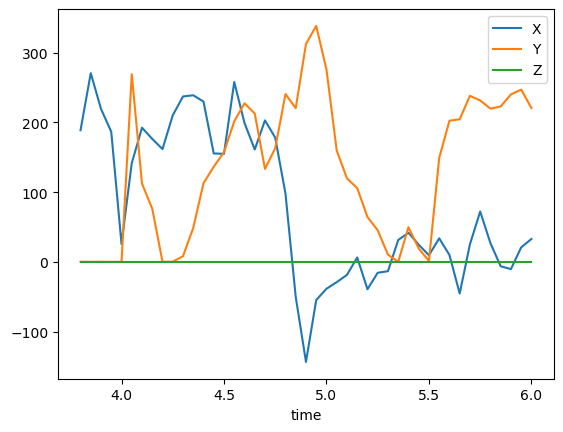

In [347]:
assistive_force = df_assist_false[["time", "/forceset/reserve_jointset_ground_pelvis_pelvis_tx", "/forceset/reserve_jointset_ground_pelvis_pelvis_ty"]]
assistive_force.set_index("time", inplace=True)
assistive_force.columns = ["X", "Y"]
assistive_force.insert(2, "Z", 0)
assistive_force *= config_file_false["reserve_pelvis_opt_value"]
assistive_force.plot()

### Crop cycle 0 to 100% based on kinematics

,X,Y,Z
time,,,
4.000,25.677987,0.008319,0
4.025,83.669819,134.666375,0
4.050,141.661651,269.324430,0
4.075,167.073182,190.759310,0
4.100,192.484714,112.194189,0
...,...,...,...
5.700,25.203352,238.215334,0
5.725,48.709112,234.911038,0
5.750,72.214873,231.606742,0


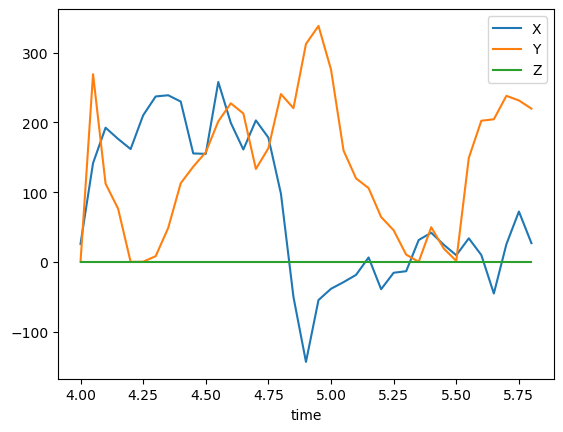

In [348]:
t0 = 4
tf = 5.8
assistive_force = assistive_force.loc[(assistive_force.index >= t0) & (assistive_force.index <= tf), :]
df_simulation_before = df_simulation_before.loc[(df_simulation_before.time >= t0) & (df_simulation_before.time <= tf), :]
df_simulation = df_simulation.loc[(df_simulation.time >= t0) & (df_simulation.time <= tf), :]
df_ground_truth = df_ground_truth.loc[(df_ground_truth.time >= t0) & (df_simulation.time <= tf), :]

assistive_force.plot()
assistive_force

### Interpolation assistive profile and pelvis kinematics

360


<Axes: xlabel='Time'>

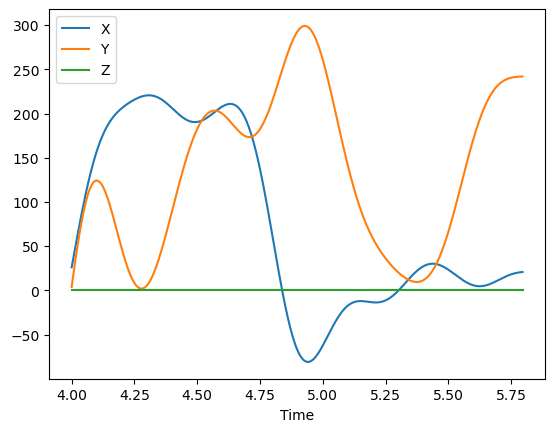

In [349]:
interpol_force_profile = assistive_force.copy()
interpol_force_profile = interpolate_dataframe(df=assistive_force, desired_frequency=200)
print(len(interpol_force_profile))
interpol_force_profile_before_low_pass = interpol_force_profile.copy()
#interpol_force_profile = smooth_dataframe(df=interpol_force_profile, window_size=10)

cutoff = 3  # Adjust this based on your needs (e.g., 20 Hz cutoff)
interpol_force_profile = butterworth_low_pass(df=interpol_force_profile, cutoff=cutoff)
interpol_force_profile.plot()

In [350]:
interpol_force_profile

,X,Y,Z
Time,,,
4.000,25.990461,3.765516,0.0
4.005,33.856452,14.270404,0.0
4.010,41.701738,24.530484,0.0
4.015,49.502801,34.495678,0.0
4.020,57.236638,44.117611,0.0
...,...,...,...
5.775,19.966371,241.587555,0.0
5.780,20.214747,241.692349,0.0
5.785,20.426867,241.772952,0.0


In [351]:
motion_percentage = (interpol_force_profile.index - interpol_force_profile.index.min())/(interpol_force_profile.index.max() - interpol_force_profile.index.min()) * 100
len(motion_percentage)


360

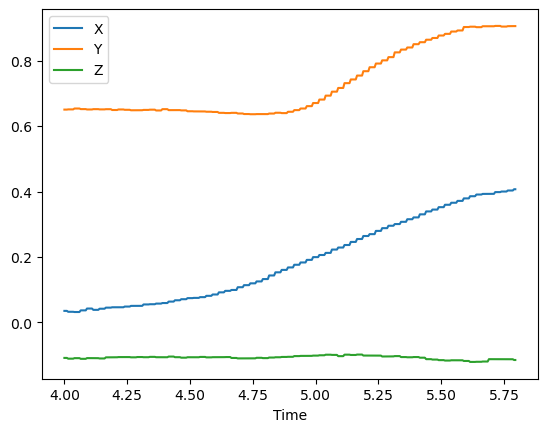

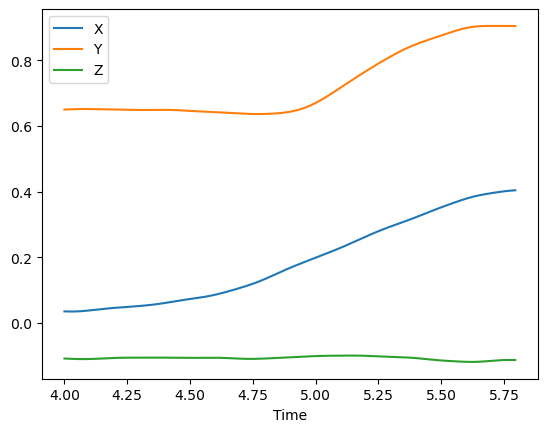

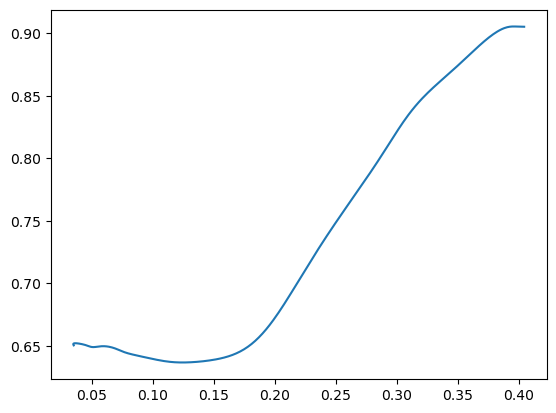

In [352]:
pelvis_x = df_ground_truth["pelvis_tx"]
pelvis_y = df_ground_truth["pelvis_ty"]
pelvis_z = df_ground_truth["pelvis_tz"]

pelvis_marker = pd.DataFrame({"Time": df_ground_truth.time, "X": pelvis_x, "Y": pelvis_y, "Z": pelvis_z})
pelvis_marker.set_index("Time", inplace=True)
interpol_pelvis_marker = interpolate_dataframe(df=pelvis_marker, desired_frequency=200)
interpol_pelvis_marker.plot()

cutoff = 5  # Adjust this based on your needs (e.g., 20 Hz cutoff)
interpol_pelvis_marker = butterworth_low_pass(df=interpol_pelvis_marker, cutoff=cutoff)
#new_index = pd.Index(np.arange(pelvis_marker.index.min(), pelvis_marker.index.max() + 0.025, step=0.025), name="Time")
#pelvis_marker_aligned = pelvis_marker.reindex(new_index, method="nearest")
#pelvis_marker_aligned = smooth_dataframe(pelvis_marker_aligned, window_size=5)
interpol_pelvis_marker.plot()
plt.show()

plt.plot(interpol_pelvis_marker.X,interpol_pelvis_marker.Y)
plt.show()

### Scale assistive force

In [353]:
# Scale down force profile
#assistive_force *= 1/20
#assistive_force.plot()

### Compute Torques profiles before scaling and simplification

In [354]:
# Get distance vector from pelvis to anchor point
#chair_position = np.array([-0.6, 0.5, -0.075]) Xabi Position
chair_position = np.array([-0.1, 0.5, -0.075])
interpol_pelvis_to_chair = chair_position - interpol_pelvis_marker

print(f"Anchoring point on bench: {interpol_pelvis_to_chair.X.iloc[0]:.3f}m away from pelvis")

Anchoring point on bench: -0.135m away from pelvis


In [355]:
l1=0.44
l2=0.41
torques, joint_angles, jacobians = compute_torque_profiles(l1, l2, F=interpol_force_profile, position=interpol_pelvis_to_chair)
print(torques)

          tau_1      tau_2
0     -3.399697  -8.877894
1     -3.169669 -14.164531
2     -2.974240 -19.378692
3     -2.815827 -24.499085
4     -2.696459 -29.504974
..          ...        ...
355  113.497940   7.199919
356  113.529593   7.186518
357  113.555944   7.178422
358  113.577958   7.174666
359  113.596377   7.174284

[360 rows x 2 columns]


Maximum torque for motor 1: 113.60 Nm
Maximum torque for motor 2: 114.08 Nm


<Axes: xlabel='Time'>

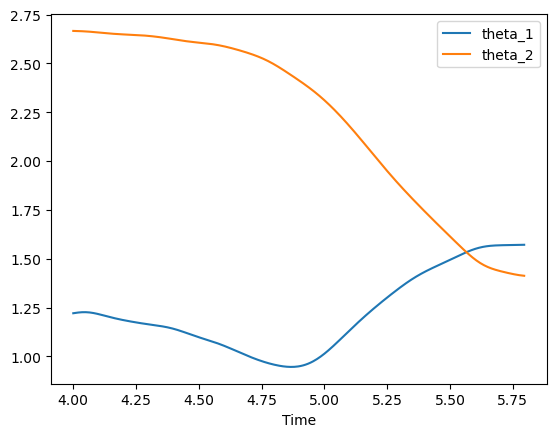

In [356]:
l1=l1
l2=l2
tau_1=torques.tau_1
tau_2=torques.tau_2
theta_1=joint_angles.theta_1
theta_2=joint_angles.theta_2
jacobians=jacobians
print(f"Maximum torque for motor 1: {abs(tau_1).max():.2f} Nm")
print(f"Maximum torque for motor 2: {abs(tau_2).max():.2f} Nm")

interpol_optimal_profile = pd.DataFrame({'theta_1': theta_1.to_numpy(), 'theta_2': theta_2.to_numpy()}, index=theta_1.index)
time = interpol_force_profile.index.values
theta_1_dot = np.gradient(interpol_optimal_profile.theta_1, time)
theta_2_dot = np.gradient(interpol_optimal_profile.theta_2, time)

interpol_optimal_profile.plot()

In [357]:
print(len(interpol_optimal_profile.index))
print(len(interpol_force_profile.index))
print(len(interpol_pelvis_to_chair))
print(len(motion_percentage))

360
360
360
360


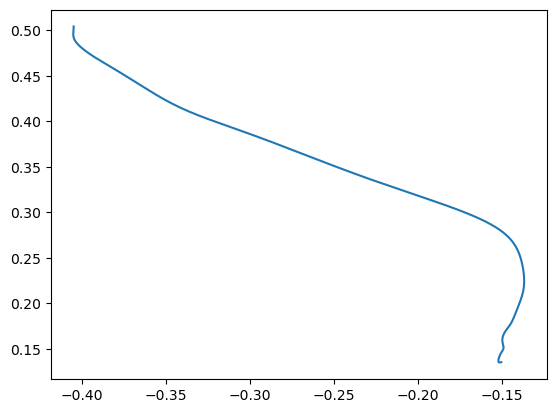

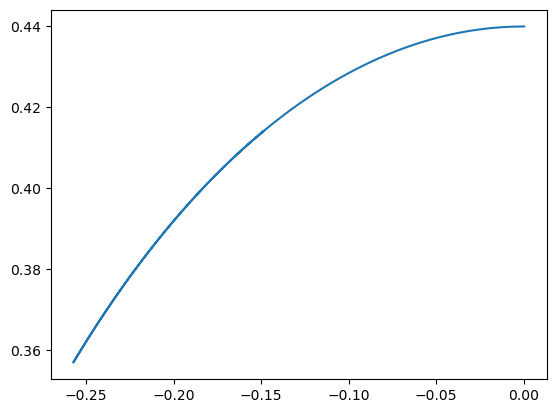

In [358]:
# Calculate End Effector and Elbow trajecotries based on optimal link length
rotate_90 = get_rotation_matrix(90)

P_EE = np.array([l1*np.cos(theta_1) + l2*np.cos(theta_1 + theta_2), l1*np.sin(theta_1) + l2*np.sin(theta_1 + theta_2)])
P_L1 = np.array([l1*np.cos(theta_1), l1*np.sin(theta_1)])

P_L1 = pd.DataFrame(P_L1.T, columns=["X", "Y"], index=theta_1.index)
P_EE = pd.DataFrame(P_EE.T, columns=["X", "Y"], index=theta_1.index)
P_EE.columns = ["X", "Y"]
P_L1.columns = ["X", "Y"]
plt.plot(P_EE["X"],P_EE["Y"])
plt.show()
plt.plot(-P_L1["X"],P_L1["Y"])
plt.show()

interpol_optimal_profile['EE_X'] = P_EE.X
interpol_optimal_profile['EE_Y'] = P_EE.Y

#motion_percentage = (optimal_profile.index - optimal_profile.index.min())/(optimal_profile.index.max() - optimal_profile.index.min()) * 100

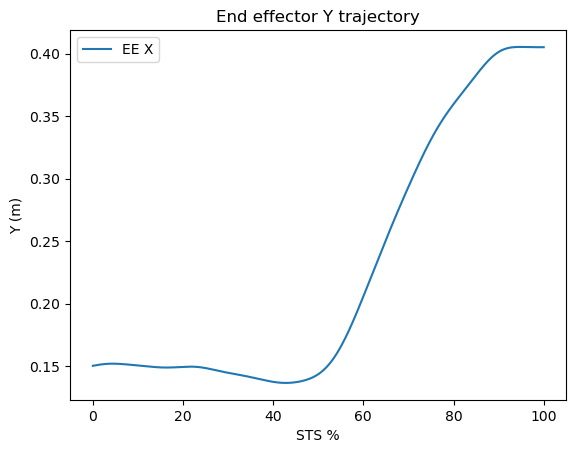

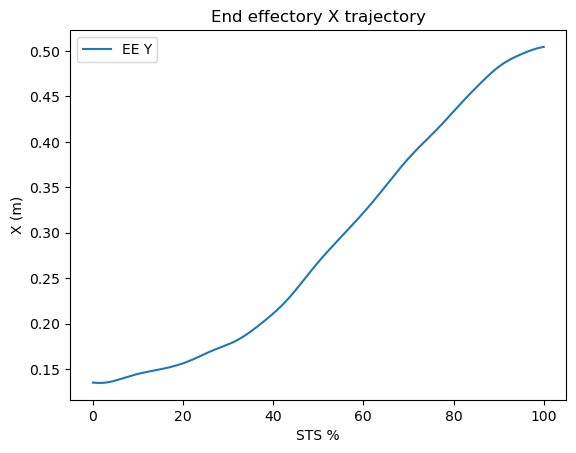

In [359]:
# why switch?? 

plt.plot(motion_percentage, -interpol_optimal_profile['EE_X'], label='EE X')
plt.xlabel("STS %")
plt.ylabel("Y (m)")
plt.title("End effector Y trajectory")
plt.legend()
#plt.savefig("../paper_figures/ee_y_trajectory.svg", format="svg")
plt.show()

plt.plot(motion_percentage, interpol_optimal_profile['EE_Y'], label='EE Y')
plt.xlabel("STS %")
plt.ylabel("X (m)")
plt.title("End effectory X trajectory")
plt.legend()
#plt.savefig("../paper_figures/ee_y_trajectory.svg", format="svg")
plt.show()

### Simplify assistive profile

In [360]:
#modified_force_profile_y = isolate_central_peak(interpol_force_profile, valley_index_before=-2, valley_index_after=0, coordinate='Y')
modified_force_profile_y = isolate_central_peak_bis(interpol_force_profile, valley_index_before=-2, valley_index_after=0, coordinate='Y')
modified_force_profile_x = interpolate_to_zero_start(interpol_force_profile, coordinate='X')
modified_force_profile_x2 = zero_after_nth_crossing(modified_force_profile_x, coord='X', n_crossing=2)

# Check if the indexes are identical
if not modified_force_profile_x2.index.equals(modified_force_profile_y.index):
    print("Warning: The indexes of the two DataFrames are not identical. This may lead to misaligned data.")

# Create a new DataFrame with the desired columns
modified_force_profile = pd.DataFrame({
    'X': modified_force_profile_x2['X'],
    'Y': modified_force_profile_y['Y'],
    'Z': modified_force_profile_y['Z']
}, index=modified_force_profile_x2.index)

if assist_only_y:
    modified_force_profile.X=0

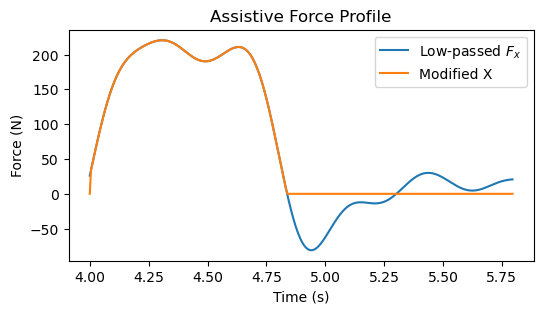

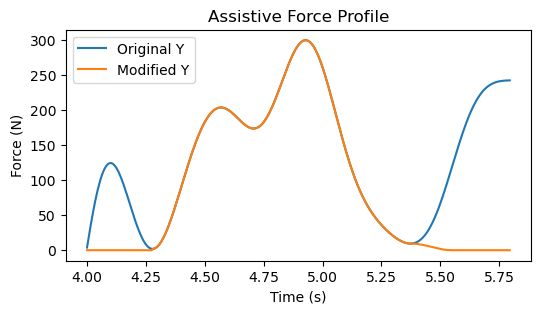

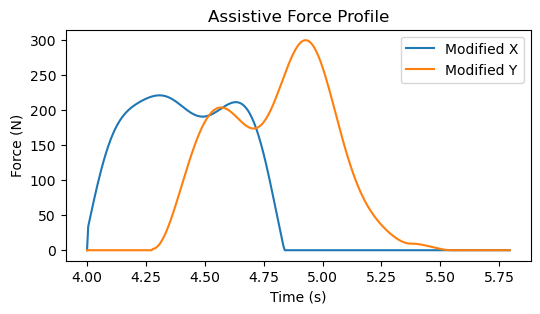

In [361]:
# Plot the result
plt.figure(figsize=(6, 3))
plt.plot(interpol_force_profile.index, interpol_force_profile['X'], label='Low-passed $F_x$')
plt.plot(modified_force_profile.index, modified_force_profile['X'], label='Modified X')
plt.title('Assistive Force Profile')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(interpol_force_profile.index, interpol_force_profile['Y'], label='Original Y')
plt.plot(modified_force_profile.index, modified_force_profile['Y'], label='Modified Y')
plt.title('Assistive Force Profile')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(modified_force_profile.index, modified_force_profile['X'], label='Modified X')
plt.plot(modified_force_profile.index, modified_force_profile['Y'], label='Modified Y')
plt.title('Assistive Force Profile')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend()
plt.show()

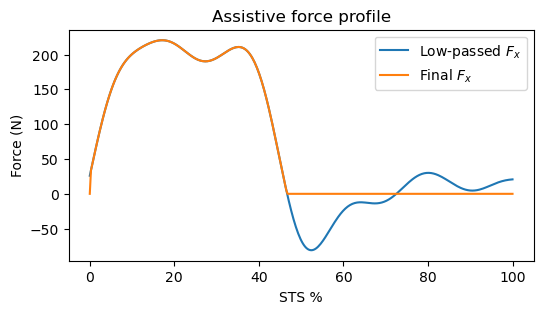

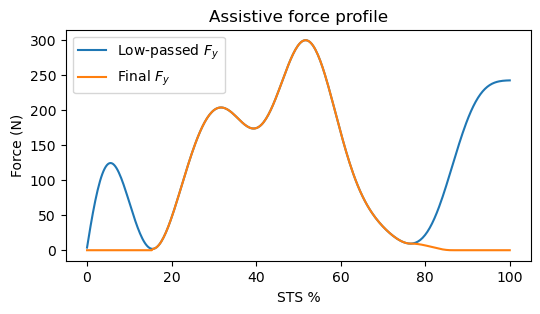

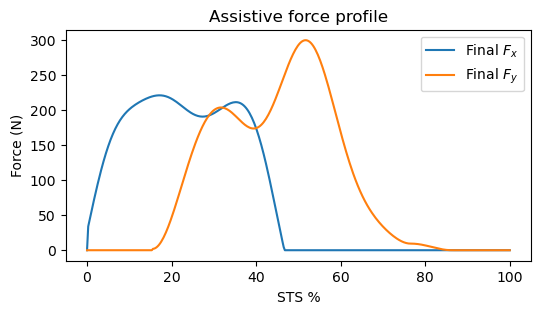

In [362]:
plt.figure(figsize=(6, 3))
plt.plot(motion_percentage, interpol_force_profile.X, label=r"Low-passed $F_x$")
plt.plot(motion_percentage, modified_force_profile.X, label=r"Final $F_x$")
plt.xlabel("STS %")
plt.ylabel("Force (N)")
plt.legend()
plt.title("Assistive force profile")
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(motion_percentage, interpol_force_profile.Y, label=r"Low-passed $F_y$")
plt.plot(motion_percentage, modified_force_profile.Y, label=r"Final $F_y$")
plt.xlabel("STS %")
plt.ylabel("Force (N)")
plt.legend()
plt.title("Assistive force profile")
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(motion_percentage, modified_force_profile.X, label=r"Final $F_x$")
plt.plot(motion_percentage, modified_force_profile.Y, label=r"Final $F_y$")
plt.xlabel("STS %")
plt.ylabel("Force (N)")
plt.legend()
plt.title("Assistive force profile")
plt.show()

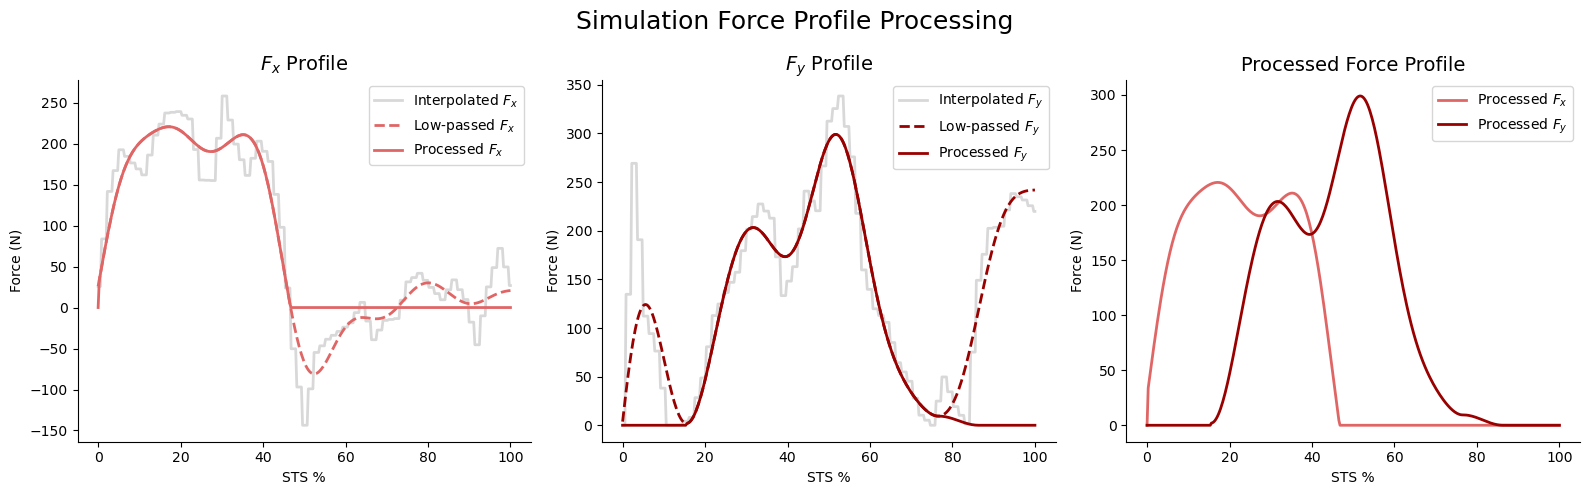

In [363]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for a more professional look
#sns.set_style("whitegrid")
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.size'] = 10

# Define colors to match the schematic
fx_color = '#e06666'  # Light pink for Fx
fy_color = '#990000'  # Dark red for Fy

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Simulation Force Profile Processing", fontsize=18)

# Plot 1: Fx comparison
ax1.plot(motion_percentage, interpol_force_profile_before_low_pass.X, label=r"Interpolated $F_x$", color='gray', linewidth=2, alpha=0.3)
ax1.plot(motion_percentage, interpol_force_profile.X, label=r"Low-passed $F_x$", color=fx_color, linestyle='--', linewidth=2)
ax1.plot(motion_percentage, modified_force_profile.X, label=r"Processed $F_x$", color=fx_color, linewidth=2)
ax1.set_xlabel("STS %")
ax1.set_ylabel("Force (N)")
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title(r"$F_x$ Profile", fontsize=14)

# Plot 2: Fy comparison
ax2.plot(motion_percentage, interpol_force_profile_before_low_pass.Y, label=r"Interpolated $F_y$", color='gray', linewidth=2, alpha=0.3)
ax2.plot(motion_percentage, interpol_force_profile.Y, label=r"Low-passed $F_y$", color=fy_color, linestyle='--', linewidth=2)
ax2.plot(motion_percentage, modified_force_profile.Y, label=r"Processed $F_y$", color=fy_color, linewidth=2)
ax2.set_xlabel("STS %")
ax2.set_ylabel("Force (N)")
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title(r"$F_y$ Profile", fontsize=14)

# Plot 3: Final Fx and Fy
ax3.plot(motion_percentage, modified_force_profile.X, label=r"Processed $F_x$", color=fx_color, linewidth=2)
ax3.plot(motion_percentage, modified_force_profile.Y, label=r"Processed $F_y$", color=fy_color, linewidth=2)
ax3.set_xlabel("STS %")
ax3.set_ylabel("Force (N)")
ax3.legend()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_title("Processed Force Profile", fontsize=14)

# Adjust layout and display
plt.tight_layout()
#plt.savefig("/Users/camilleguillaume/Documents/MasterThesis/figures_rapport/force_profile_processing", bbox_inches="tight")
plt.show()

### Compute torques profiles after simplification

In [364]:
modified_force_profile_reset = modified_force_profile.reset_index()
index_where_X_is_zero = modified_force_profile_reset[2:][modified_force_profile_reset['X'] == 0].index[0]

# Print the result
print(f"The first index where 'X' goes to 0 after skipping the start is: {index_where_X_is_zero}")

The first index where 'X' goes to 0 after skipping the start is: 168


/var/folders/3w/gl1bd25n1q78tgfp6jspsxb00000gn/T/ipykernel_9107/2101862714.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index_where_X_is_zero = modified_force_profile_reset[2:][modified_force_profile_reset['X'] == 0].index[0]


In [365]:
new_torques, new_joint_angles, new_jacobians =  compute_torque_profiles(l1=l1, l2=l2, F=modified_force_profile, position=interpol_pelvis_to_chair)

new_tau_1=new_torques.tau_1
new_tau_2=new_torques.tau_2
new_theta_1=new_joint_angles.theta_1
new_theta_2=new_joint_angles.theta_2
new_jacobians=new_jacobians

In [366]:
new_torques

,tau_1,tau_2
0,0.000000,0.000000
1,-5.098258,-10.192727
2,-6.287163,-12.545404
3,-7.471961,-14.882619
4,-8.648915,-17.198505
...,...,...
355,0.000000,0.000000
356,0.000000,0.000000
357,0.000000,0.000000
358,0.000000,0.000000


In [367]:
new_theta_1

Time
4.000    1.220746
4.005    1.221770
4.010    1.222740
4.015    1.223633
4.020    1.224429
           ...   
5.775    1.570854
5.780    1.570971
5.785    1.571083
5.790    1.571186
5.795    1.571279
Name: theta_1, Length: 360, dtype: float64

In [368]:
# Scale the torque profiles to a set MIN/MAX range
scale_factor_tau1 = motor_config["AK70-10"]['T_max'] / np.abs(new_torques.tau_1).max()
scale_factor_tau2 = motor_config["AK60-6"]['T_max'] / np.abs(new_torques.tau_2).max()
# Scaling torque profiles
print(f"Scaling factor tau1: {scale_factor_tau1:.3f}")
print(f"Scaling factor tau2: {scale_factor_tau2:.3f}")
print(f"Scaling factor tau1 with safety margin: {scale_factor_tau1*0.95:.3f}")
print(f"Scaling factor tau2 with safety margin: {scale_factor_tau2*0.95:.3f}")

print("Scaling everything by tau_2 to keep the same ratio")
scaled_optimal_profile = pd.DataFrame(index=new_theta_1.index)
if assist_scalex_scaley:
    # Apply scaling to tau_1 and tau_2 before index_where_X_is_zero
    scaled_optimal_profile = scaled_optimal_profile.reset_index()
    scaled_optimal_profile.loc[0:index_where_X_is_zero, "tau_1"] = new_torques.loc[0:index_where_X_is_zero, "tau_1"].to_numpy() * scale_factor_tau2
    scaled_optimal_profile.loc[0:index_where_X_is_zero, "tau_2"] = new_torques.loc[0:index_where_X_is_zero, "tau_2"].to_numpy() * scale_factor_tau2
    # Apply scaling to tau_1 and tau_2 after index_where_X_is_zero
    scaled_optimal_profile.loc[index_where_X_is_zero:, "tau_1"] = new_torques.loc[index_where_X_is_zero:, "tau_1"].to_numpy() * scale_factor_tau1
    scaled_optimal_profile.loc[index_where_X_is_zero:, "tau_2"] = new_torques.loc[index_where_X_is_zero:, "tau_2"].to_numpy() * scale_factor_tau1
    scaled_optimal_profile.index=new_theta_1.index
else:
    scaled_optimal_profile["tau_1"] = new_torques.tau_1.to_numpy() * scale_factor_tau2
    scaled_optimal_profile["tau_2"] = new_torques.tau_2.to_numpy() * scale_factor_tau2 

# No scaling theta_1, theta_2
scaled_optimal_profile["theta_1"] = new_theta_1
scaled_optimal_profile["theta_2"] = new_theta_2
time = interpol_force_profile.index.values
scaled_optimal_profile["theta_1_dot"] = np.gradient(new_theta_1, time)
scaled_optimal_profile["theta_2_dot"] = np.gradient(new_theta_2, time)

scaled_optimal_profile

Scaling factor tau1: 0.286
Scaling factor tau2: 0.079
Scaling factor tau1 with safety margin: 0.272
Scaling factor tau2 with safety margin: 0.075
Scaling everything by tau_2 to keep the same ratio


,tau_1,tau_2,theta_1,theta_2,theta_1_dot,theta_2_dot
Time,,,,,,
4.000,0.000000,0.000000,1.220746,2.666168,0.204655,-0.032627
4.005,-0.402228,-0.804157,1.221770,2.666005,0.199330,-0.034066
4.010,-0.496027,-0.989772,1.222740,2.665828,0.186365,-0.037311
4.015,-0.589502,-1.174167,1.223633,2.665632,0.168896,-0.041263
4.020,-0.682358,-1.356879,1.224429,2.665415,0.147234,-0.045857
...,...,...,...,...,...,...
5.775,0.000000,0.000000,1.570854,1.415774,0.024081,-0.194262
5.780,0.000000,0.000000,1.570971,1.414844,0.022904,-0.177411
5.785,0.000000,0.000000,1.571083,1.414000,0.021423,-0.159800


In [369]:
# Recalculate force based on scaled torques
scaled_torques = scaled_optimal_profile[["tau_1", "tau_2"]].to_numpy()
N, M = scaled_torques.shape
scaled_torques = scaled_torques.reshape(N, M, 1)

# Inverse operation for getting force profile from torques
F = - rotate_90[:2, :2] @ np.linalg.inv(new_jacobians.T) @ scaled_torques

scaled_optimal_profile['force_X'] = F[:, 0]
scaled_optimal_profile['force_Y'] = F[:, 1]

rotate_90 = get_rotation_matrix(90)
P_EE_scaled = np.array([l1*np.cos(new_theta_1) + l2*np.cos(new_theta_1 + new_theta_2), l1*np.sin(new_theta_1) + l2*np.sin(new_theta_1 + new_theta_2)])
P_L1_scaled = np.array([l1*np.cos(new_theta_1), l1*np.sin(new_theta_1)])
P_EE_scaled = pd.DataFrame(P_EE_scaled.T, columns=["X", "Y"], index=new_theta_1.index)
P_L1_scaled = pd.DataFrame(P_L1_scaled.T, columns=["X", "Y"], index=new_theta_1.index)
P_EE_scaled.columns = ["X", "Y"]
P_L1_scaled.columns = ["X", "Y"]

scaled_optimal_profile['EE_X'] = P_EE_scaled.X
scaled_optimal_profile['EE_Y'] = P_EE_scaled.Y
scaled_optimal_profile['L1_X'] = P_L1_scaled.X
scaled_optimal_profile['L1_Y'] = P_L1_scaled.Y

<Axes: xlabel='Time'>

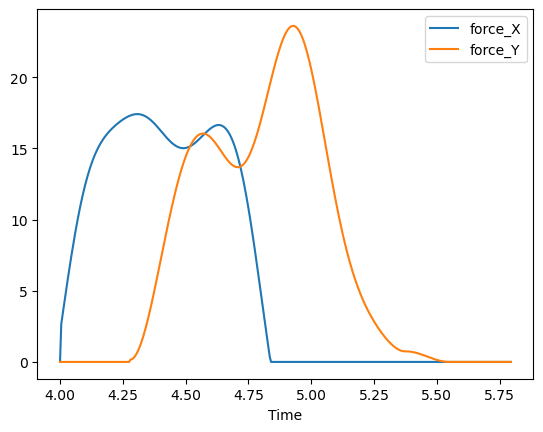

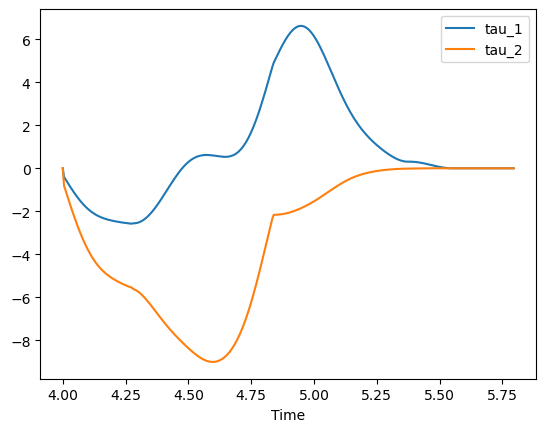

In [370]:
scaled_optimal_profile[['force_X', 'force_Y']].plot()
scaled_optimal_profile[["tau_1", "tau_2"]].plot()

X    0.404402
Y    0.905123
Z   -0.112847
Name: 5.794999999999962, dtype: float64


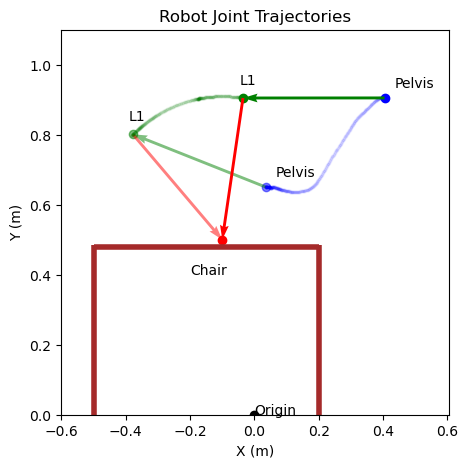

In [371]:
def plot_device_trajectory(pelvis_positions, pelvis_to_chair_positions, P_EE, P_L1, chair_position, force_profile, display_force = False):
    
    rotate_90 = get_rotation_matrix(90)  # Ensure this gets a 2D rotation matrix.
    timestep = 0
    P_EE['Z'] = 0
    P_L1['Z'] = 0

    # Scale factor for force vectors (adjust as needed)
    force_scale = 0.003  # This will make 1 Newton = 0.01 meters in the plot

    plt.figure(figsize=(5, 5))
    ax = plt.axes()  # No projection needed.

    for timestep in range(len(pelvis_positions)): 
        pelvis_pos = pelvis_positions.iloc[timestep]
        if timestep == len(pelvis_positions)-1:
            print(pelvis_pos)
        pelvis_chair = pelvis_to_chair_positions.iloc[timestep].T

        l1_vector = rotate_90 @ P_L1.iloc[timestep].T
        l1_origin = pelvis_pos
        l1_pos = pelvis_pos + l1_vector

        l2_pos = rotate_90 @ P_EE.iloc[timestep].T
        l2_origin = l1_pos
        l2_vector = l2_pos - l1_vector

        ee_pos = pelvis_pos + l2_pos

        ax.scatter(*pelvis_pos[:2], color="b", s=3, alpha=0.05)  
        ax.scatter(*l1_pos[:2], color="g", s=3, alpha=0.05)  

        if timestep == 0 or timestep == len(pelvis_positions)-1:
            ax.text(*pelvis_pos[:2] + 0.03, "Pelvis", horizontalalignment='left')
            ax.text(*l1_pos[:2] + 0.04 , "L1", horizontalalignment='right')

            if timestep == 0:
                ax.scatter(*pelvis_pos[:2], color="b", alpha=0.5)
                ax.scatter(*l1_pos[:2], color="g", alpha=0.5)
                ax.quiver(*l1_origin[:2], *l1_vector[:2], color="g", angles='xy', scale_units='xy', scale=1, alpha=0.5)
                ax.quiver(*l2_origin[:2], *l2_vector[:2], color="r", angles='xy', scale_units='xy', scale=1, alpha=0.5)
            else:
                ax.scatter(*pelvis_pos[:2], color="b")
                ax.scatter(*l1_pos[:2], color="g")
                ax.quiver(*l1_origin[:2], *l1_vector[:2], color="g", angles='xy', scale_units='xy', scale=1)
                ax.quiver(*l2_origin[:2], *l2_vector[:2], color="r", angles='xy', scale_units='xy', scale=1)

        if display_force == True:
            # Plot force vector
            force_x = force_profile['force_X'].iloc[timestep]
            force_y = force_profile['force_Y'].iloc[timestep]
            force_magnitude = np.sqrt(force_x**2 + force_y**2)
            
            if force_magnitude > 0:
                ax.quiver(*pelvis_pos[:2], force_x * force_scale, force_y * force_scale, 
                        color="m", angles='xy', scale_units='xy', scale=1, 
                        width=0.005, alpha=0.2)

    ax.scatter(*chair_position[:2], color="r")
    ax.text(*chair_position[:2] - 0.1, "Chair")

    origin = [0, 0]
    ax.scatter(*origin, color="k")
    ax.text(*origin, "Origin")

    ax.hlines(y=chair_position[1]-0.02, xmin=-0.5, xmax=0.2, linewidth=4, color='brown')
    ax.vlines(x=-0.5, ymin=0, ymax=chair_position[1]-0.015, linewidth=4, color='brown')
    ax.vlines(x=0.2, ymin=0, ymax=chair_position[1]-0.015, linewidth=4, color='brown')
    # No longer use pelvis_pos and pelvis_chair for 3D quiver.

    ax.set_xlim([-0.6, pelvis_positions['X'].max()+ 0.2] )
    ax.set_ylim([0, 1.1])

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title("Robot Joint Trajectories")

    #plt.savefig("/Users/camilleguillaume/Documents/MasterThesis/figures_rapport/robot_joint_trajectories")
    plt.show()


plot_device_trajectory(interpol_pelvis_marker, interpol_pelvis_to_chair, P_EE_scaled, P_L1_scaled, chair_position, scaled_optimal_profile, display_force=False)
#plot_device_trajectory(interpol_pelvis_marker, interpol_pelvis_to_chair, P_EE_scaled, P_L1_scaled, chair_position, scaled_optimal_profile, display_force=True)

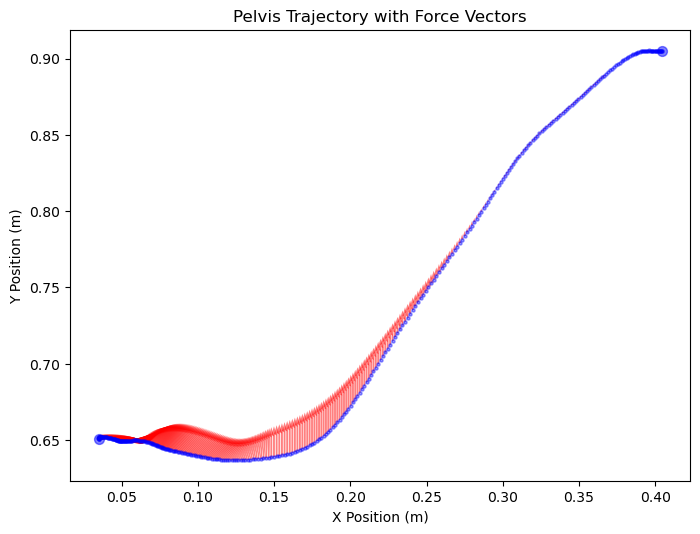

In [372]:
def plot_pelvis_trajectory_and_force(pelvis_marker, force_profile, force_scale=0.001):
    plt.figure(figsize=(8, 8))
    ax = plt.axes()

    # Plot pelvis trajectory
    ax.plot(pelvis_marker['X'], pelvis_marker['Y'], 'b-', linewidth=1, alpha=0.2)

    # Plot force vectors
    for i in range(len(pelvis_marker)):
        pelvis_pos = pelvis_marker.iloc[i][['X', 'Y']]
        force = force_profile.iloc[i][['X', 'Y']]
        
        force_magnitude = np.linalg.norm(force)
        if force_magnitude > 0:
            ax.quiver(pelvis_pos['X'], pelvis_pos['Y'], 
                      force['X'] * force_scale, force['Y'] * force_scale,
                      color='r', angles='xy', scale_units='xy', scale=1,
                      width=0.003, alpha=0.5)

    # Mark start and end points
    ax.scatter(pelvis_marker['X'].iloc[0], pelvis_marker['Y'].iloc[0], color='b', s=50, alpha=0.5)
    ax.scatter(pelvis_marker['X'].iloc[-1], pelvis_marker['Y'].iloc[-1], color='b', s=50, alpha=0.5)

    # Set labels and title
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_title('Pelvis Trajectory with Force Vectors')

    # Set aspect ratio to equal for true scaling
    ax.set_aspect('equal', 'box')

    # Add colorbar to represent time
    ax.scatter(pelvis_marker['X'], pelvis_marker['Y'], color='b', s=5, alpha=0.4)
    # Show the plot
    plt.show()


# Call the function with your data
force_profile = pd.DataFrame(index=modified_force_profile.index)
force_profile['X'] = scaled_optimal_profile["force_X"]
force_profile['Y'] = scaled_optimal_profile["force_Y"]

plot_pelvis_trajectory_and_force(interpol_pelvis_marker, force_profile, force_scale=0.001)

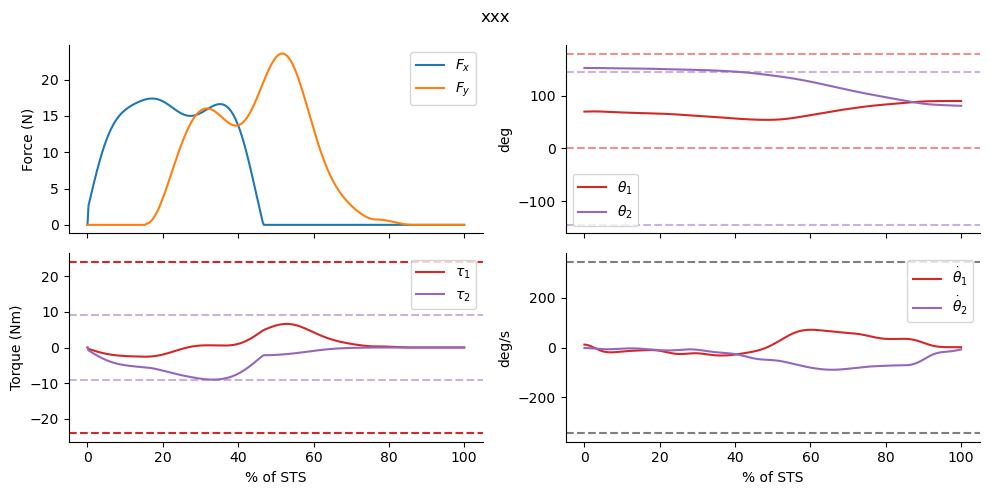

In [373]:
# Set joint angle limits (degrees)
theta_1_lims = [0, 180]
theta_2_lims = [-145, 145]

fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True)
fig.suptitle("xxx")
axs[0, 0].plot(motion_percentage, scaled_optimal_profile[['force_X', 'force_Y']])
axs[0, 0].set_ylabel("Force (N)")
axs[0, 0].legend([r"$F_x$", r"$F_y$"])
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)
axs[0, 0].spines['bottom'].set_visible(True)
axs[0, 0].spines['left'].set_visible(True)
#axs[0, 0].grid()

axs[1, 0].plot(motion_percentage, scaled_optimal_profile.tau_1, label=r"$\tau_1$", color="C3")
axs[1, 0].axhline(y=motor_config["AK70-10"]['T_max'], linestyle="--", color="C3")
axs[1, 0].axhline(y=motor_config["AK70-10"]['T_min'], linestyle="--", color="C3")
axs[1, 0].plot(motion_percentage, scaled_optimal_profile.tau_2, label=r"$\tau_2$", color="C4")
axs[1, 0].axhline(y=motor_config["AK60-6"]['T_max'], linestyle="--", color="C4", alpha=0.5)
axs[1, 0].axhline(y=motor_config["AK60-6"]['T_min'], linestyle="--", color="C4", alpha=0.5)
axs[1, 0].legend()
axs[1, 0].set_xlabel("% of STS")
axs[1, 0].set_ylabel("Torque (Nm)")
axs[1, 0].spines['top'].set_visible(False)
axs[1, 0].spines['right'].set_visible(False)
axs[1, 0].spines['bottom'].set_visible(True)
axs[1, 0].spines['left'].set_visible(True)
#axs[1, 0].grid()

axs[0, 1].plot(motion_percentage, np.degrees(scaled_optimal_profile.theta_1), label=r"$\theta_1$", color="C3")
axs[0, 1].axhline(y=theta_1_lims[0], linestyle="--", color="C3", alpha=0.5)
axs[0, 1].axhline(y=theta_1_lims[1], linestyle="--", color="C3", alpha=0.5)
axs[0, 1].plot(motion_percentage, np.degrees(scaled_optimal_profile.theta_2), label=r"$\theta_2$", color="C4")
axs[0, 1].axhline(y=theta_2_lims[0], linestyle="--", color="C4", alpha=0.5)
axs[0, 1].axhline(y=theta_2_lims[1], linestyle="--", color="C4", alpha=0.5)
axs[0, 1].legend()
axs[0, 1].set_ylabel("deg")
axs[0, 1].spines['top'].set_visible(False)
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].spines['bottom'].set_visible(True)
axs[0, 1].spines['left'].set_visible(True)
#axs[0, 1].grid()

# Add dashed line for max rad/s with label
axs[1, 1].plot(motion_percentage, np.degrees(scaled_optimal_profile["theta_1_dot"]), label=r"$\dot\theta_1$", color="C3")
axs[1, 1].plot(motion_percentage, np.degrees(scaled_optimal_profile["theta_2_dot"]), label=r"$\dot\theta_2$", color="C4")
axs[1, 1].axhline(y=np.degrees(6), linestyle="--", color="k", alpha=0.5)
axs[1, 1].axhline(y=np.degrees(-6), linestyle="--", color="k", alpha=0.5)
#axs[1, 1].grid()
axs[1, 1].legend()
axs[1, 1].set_xlabel("% of STS")
axs[1, 1].set_ylabel("deg/s")
axs[1, 1].spines['top'].set_visible(False)
axs[1, 1].spines['right'].set_visible(False)
axs[1, 1].spines['bottom'].set_visible(True)
axs[1, 1].spines['left'].set_visible(True)

plt.tight_layout()

#plt.savefig("../paper_figures/optimal_profiles_combined.svg", format="svg")

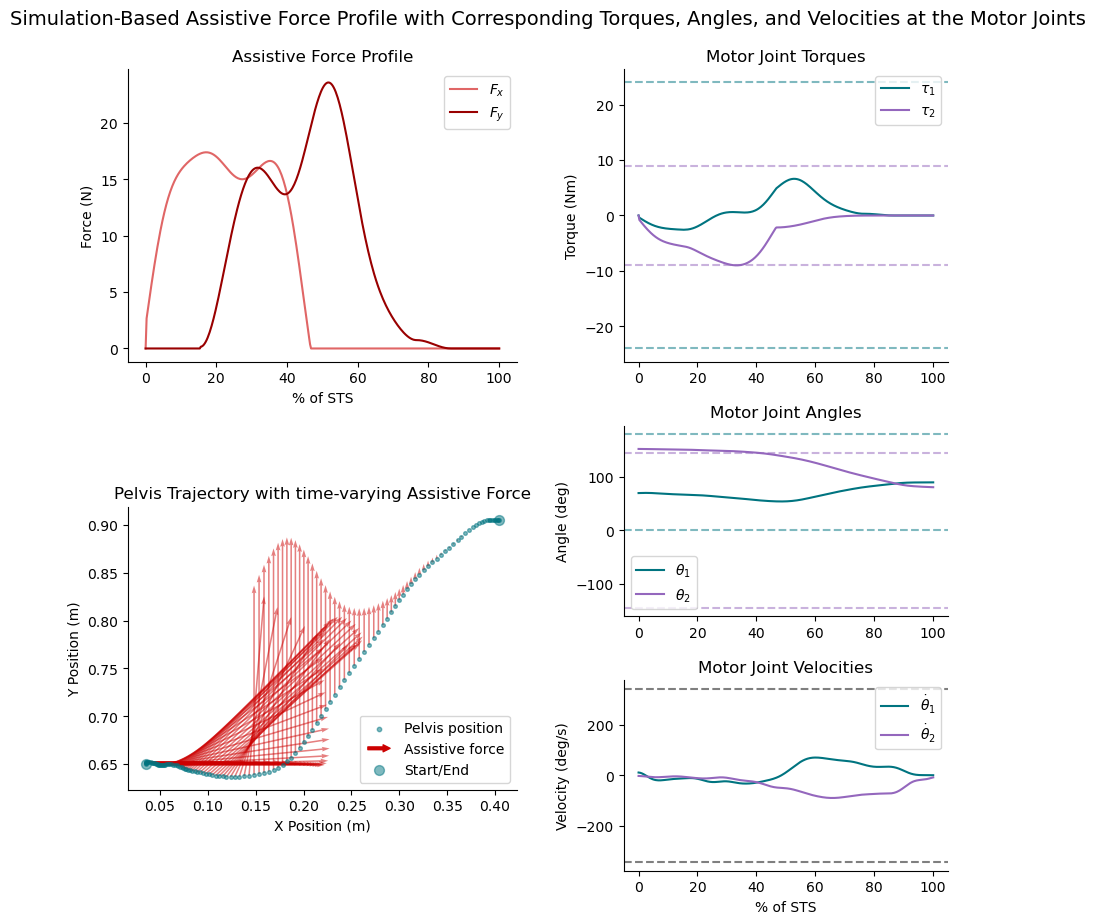

In [374]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Custom handler for arrow in legend
class ArrowHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        arrow = mpatches.FancyArrowPatch((x0, y0+height/2), (x0+width, y0+height/2),
                                         mutation_scale=10, color=color_f)
        handlebox.add_artist(arrow)
        return arrow

color_f = '#cc0000'
color_m1 = '#007480'
color_m2 = '#00a79f' 

# Set joint angle limits (degrees)
theta_1_lims = [0, 180]
theta_2_lims = [-145, 145]

# Create a figure with a custom grid
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(5, 2, width_ratios=[1.2, 1], height_ratios=[0.6, 0.6, 1, 1, 1])

# Create the force profile plot
ax_force = fig.add_subplot(gs[0:2, 0])
ax_force.plot(motion_percentage, scaled_optimal_profile.force_X, color=fx_color)
ax_force.plot(motion_percentage, scaled_optimal_profile.force_Y, color=fy_color)
#scaled_optimal_profile["force_magnitude"] = scaled_optimal_profile.apply(lambda row: np.linalg.norm([row['force_X'], row['force_Y']]), axis=1)
#ax_force.plot(motion_percentage, scaled_optimal_profile["force_magnitude"])
ax_force.set_ylabel("Force (N)")
ax_force.legend([r"$F_x$", r"$F_y$"])
ax_force.spines['top'].set_visible(False)
ax_force.spines['right'].set_visible(False)
ax_force.set_title("Assistive Force Profile")
ax_force.set_xlabel("% of STS")

if assist_scalex_scaley:
    scale_vector_force = 0.4
elif assist_only_y:
    scale_vector_force = 0.4
else:
    scale_vector_force = 0.1

# Create the pelvis trajectory plot
ax_pelvis = fig.add_subplot(gs[2:4, 0])
#ax_pelvis.plot(interpol_pelvis_marker['X'], interpol_pelvis_marker['Y'], color_m1, linewidth=1, alpha=0.2)
# Plot every other pelvis position and force arrow
for i in range(0, len(interpol_pelvis_marker), 3):
    pelvis_pos = interpol_pelvis_marker.iloc[i][['X', 'Y']]
    force = force_profile.iloc[i][['X', 'Y']]
    force_magnitude = np.linalg.norm(force)
    if force_magnitude > 0:
        ax_pelvis.quiver(pelvis_pos['X'], pelvis_pos['Y'],
                   force['X'] * 0.001, force['Y'] * 0.001,
                   color=color_f, angles='xy', scale_units='xy', scale=scale_vector_force,
                   width=0.004, alpha=0.5)
    ax_pelvis.scatter(pelvis_pos['X'], pelvis_pos['Y'], color=color_m1, s=7, alpha=0.5)
# Plot start and end points
ax_pelvis.scatter(interpol_pelvis_marker['X'].iloc[0], interpol_pelvis_marker['Y'].iloc[0], color=color_m1, s=50, alpha=0.5)
ax_pelvis.scatter(interpol_pelvis_marker['X'].iloc[-1], interpol_pelvis_marker['Y'].iloc[-1], color=color_m1, s=50, alpha=0.5)
# Create dummy plots for legend
dummy_scatter = ax_pelvis.scatter([], [], color=color_m1, s=10, alpha=0.5, label='Pelvis position')
dummy_arrow = mlines.Line2D([], [], color=color_f, marker='>', markersize=5, linestyle='None', label='Assistive force')
dummy_start = ax_pelvis.scatter([], [], color=color_m1, s=50, alpha=0.5, label='Start/End')
# Add legend
# Add legend with custom handler for arrow
ax_pelvis.legend(handles=[dummy_scatter, dummy_arrow, dummy_start], 
                 handler_map={dummy_arrow: ArrowHandler()}, loc='lower right')
ax_pelvis.set_xlabel('X Position (m)')
ax_pelvis.set_ylabel('Y Position (m)')
ax_pelvis.spines['top'].set_visible(False)
ax_pelvis.spines['right'].set_visible(False)
ax_pelvis.set_title('Pelvis Trajectory with time-varying Assistive Force')
ax_pelvis.set_aspect('equal', 'box')

# Create the three plots on the right
ax_top_right = fig.add_subplot(gs[0:2, 1])
ax_mid_right = fig.add_subplot(gs[2, 1])
ax_bottom_right = fig.add_subplot(gs[3, 1])

# Top right plot (Joint Torques)
ax_top_right.plot(motion_percentage, scaled_optimal_profile.tau_1, label=r"$\tau_1$", color=color_m1)
ax_top_right.axhline(y=motor_config["AK70-10"]['T_max'], linestyle="--", color=color_m1, alpha=0.5)
ax_top_right.axhline(y=motor_config["AK70-10"]['T_min'], linestyle="--", color=color_m1, alpha=0.5)
ax_top_right.plot(motion_percentage, scaled_optimal_profile.tau_2, label=r"$\tau_2$", color="C4")
ax_top_right.axhline(y=motor_config["AK60-6"]['T_max'], linestyle="--", color="C4", alpha=0.5)
ax_top_right.axhline(y=motor_config["AK60-6"]['T_min'], linestyle="--", color="C4", alpha=0.5)
ax_top_right.legend()
ax_top_right.set_ylabel("Torque (Nm)")
ax_top_right.spines['top'].set_visible(False)
ax_top_right.spines['right'].set_visible(False)
ax_top_right.set_title("Motor Joint Torques")

# Middle right plot (Joint Angles)
ax_mid_right.plot(motion_percentage, np.degrees(scaled_optimal_profile.theta_1), label=r"$\theta_1$", color=color_m1)
ax_mid_right.axhline(y=theta_1_lims[0], linestyle="--", color=color_m1, alpha=0.5)
ax_mid_right.axhline(y=theta_1_lims[1], linestyle="--", color=color_m1, alpha=0.5)
ax_mid_right.plot(motion_percentage, np.degrees(scaled_optimal_profile.theta_2), label=r"$\theta_2$", color="C4")
ax_mid_right.axhline(y=theta_2_lims[0], linestyle="--", color="C4", alpha=0.5)
ax_mid_right.axhline(y=theta_2_lims[1], linestyle="--", color="C4", alpha=0.5)
ax_mid_right.legend()
ax_mid_right.set_ylabel("Angle (deg)")
ax_mid_right.spines['top'].set_visible(False)
ax_mid_right.spines['right'].set_visible(False)
ax_mid_right.set_title("Motor Joint Angles")

# Bottom right plot (Joint Velocities)
ax_bottom_right.plot(motion_percentage, np.degrees(scaled_optimal_profile["theta_1_dot"]), label=r"$\dot\theta_1$", color=color_m1)
ax_bottom_right.plot(motion_percentage, np.degrees(scaled_optimal_profile["theta_2_dot"]), label=r"$\dot\theta_2$", color="C4")
ax_bottom_right.axhline(y=np.degrees(6), linestyle="--", color="k", alpha=0.5)
ax_bottom_right.axhline(y=np.degrees(-6), linestyle="--", color="k", alpha=0.5)
ax_bottom_right.legend()
ax_bottom_right.set_xlabel("% of STS")
ax_bottom_right.set_ylabel("Velocity (deg/s)")
ax_bottom_right.spines['top'].set_visible(False)
ax_bottom_right.spines['right'].set_visible(False)
ax_bottom_right.set_title("Motor Joint Velocities")

fig.suptitle("Simulation-Based Assistive Force Profile with Corresponding Torques, Angles, and Velocities at the Motor Joints", fontsize=14, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.05, left=0.08, right=0.90, wspace=0.3, hspace=0.4)

# Uncomment the following line to save the figure
#plt.savefig("/Users/camilleguillaume/Documents/MasterThesis/figures_rapport/force_profile_and_torques", bbox_inches="tight")
plt.show()

### Save profile and send it

In [375]:
# Percentage,theta_1,theta_2,EE_X,EE_Y,tau_1,tau_2,force_X,force_Y

scaled_optimal_profile["Time"]=scaled_optimal_profile.index
scaled_optimal_profile["Percentage"]=motion_percentage
scaled_optimal_profile.set_index("Percentage", inplace=True)
scaled_optimal_profile

,tau_1,tau_2,theta_1,theta_2,theta_1_dot,theta_2_dot,force_X,force_Y,EE_X,EE_Y,L1_X,L1_Y,Time
Percentage,,,,,,,,,,,,,
0.000000,0.000000,0.000000,1.220746,2.666168,0.204655,-0.032627,0.000000,0.000000e+00,-0.150401,0.135251,0.150896,0.413316,4.000
0.278552,-0.402228,-0.804157,1.221770,2.666005,0.199330,-0.034066,2.671110,2.220446e-16,-0.150585,0.135146,0.150473,0.413471,4.005
0.557103,-0.496027,-0.989772,1.222740,2.665828,0.186365,-0.037311,3.290065,4.440892e-16,-0.150765,0.135053,0.150071,0.413616,4.010
0.835655,-0.589502,-1.174167,1.223633,2.665632,0.168896,-0.041263,3.905532,4.440892e-16,-0.150940,0.134977,0.149702,0.413750,4.015
1.114206,-0.682358,-1.356879,1.224429,2.665415,0.147234,-0.045857,4.515694,8.881784e-16,-0.151108,0.134922,0.149373,0.413869,4.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98.885794,0.000000,0.000000,1.570854,1.415774,0.024081,-0.194262,0.000000,0.000000e+00,-0.405112,0.503282,-0.000025,0.440000,5.775
99.164345,0.000000,0.000000,1.570971,1.414844,0.022904,-0.177411,0.000000,0.000000e+00,-0.405112,0.503611,-0.000077,0.440000,5.780
99.442897,0.000000,0.000000,1.571083,1.414000,0.021423,-0.159800,0.000000,0.000000e+00,-0.405115,0.503907,-0.000126,0.440000,5.785


In [376]:
modified_force_profile["Percentage"] = motion_percentage
modified_force_profile["Time"] = modified_force_profile.index
modified_force_profile.set_index("Percentage", inplace=True)
modified_force_profile

,X,Y,Z,Time
Percentage,,,,
0.000000,0.000000,0.0,0.0,4.000
0.278552,33.856452,0.0,0.0,4.005
0.557103,41.701738,0.0,0.0,4.010
0.835655,49.502801,0.0,0.0,4.015
1.114206,57.236638,0.0,0.0,4.020
...,...,...,...,...
98.885794,0.000000,0.0,0.0,5.775
99.164345,0.000000,0.0,0.0,5.780
99.442897,0.000000,0.0,0.0,5.785


In [377]:
if assist_only_y: 
    optimal_profile_path = solutions_path / "simulation_profile_Camille_y.csv"
    scaled_optimal_profile.to_csv(optimal_profile_path)
    scaled_optimal_profile.to_csv("/Users/camilleguillaume/Documents/MasterThesis/assistive-arm/torque_profiles/simulation_profile_Camille_y.csv")
if assist_scalex_scaley:
    optimal_profile_path = solutions_path / "simulation_profile_Camille_scalex_scaley.csv"
    scaled_optimal_profile.to_csv(optimal_profile_path)
    scaled_optimal_profile.to_csv("/Users/camilleguillaume/Documents/MasterThesis/assistive-arm/torque_profiles/simulation_profile_Camille_scalex_scaley.csv")
else:
    optimal_profile_path = solutions_path / "simulation_profile_Camille_xy.csv"
    scaled_optimal_profile.to_csv(optimal_profile_path)
    scaled_optimal_profile.to_csv("/Users/camilleguillaume/Documents/MasterThesis/assistive-arm/torque_profiles/simulation_profile_Camille_xy.csv")


In [378]:
"""
timeout_limit = 5 #s

command = f"timeout {timeout_limit} scp {str(optimal_profile_path)} ABILITY_LAB_WLAN:/home/xabier/ability-lab/assistive-arm/torque_profiles/"
os.system(command)

zip_file_path = Path("../torque_profiles/spline_profiles.zip").absolute()
with zipfile.ZipFile(zip_file_path, "w") as zip_file:
    for spline_path in spline_paths:
        zip_file.write(spline_path, os.path.basename(spline_path))
command = f"timeout {timeout_limit} scp {zip_file_path} ABILITY_LAB_WLAN:/home/xabier/ability-lab/assistive-arm/torque_profiles/"
os.system(command)

unzip_command = f"timeout {timeout_limit} ssh ABILITY_LAB_WLAN 'unzip -oq /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles.zip -d /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles/'"
os.system(unzip_command)
exit_status = os.system(f"timeout {timeout_limit} ssh ABILITY_LAB_WLAN 'rm /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles.zip'")
# Execute the command

# Check if the command timed out or failed
if exit_status != 0:
    if exit_status == 31744:
        print(f"Timeout: The file copy operation did not complete within {timeout_limit} seconds.")
    else:
        print(f"An error occurred with exit status {exit_status}.")
"""

'\ntimeout_limit = 5 #s\n\ncommand = f"timeout {timeout_limit} scp {str(optimal_profile_path)} ABILITY_LAB_WLAN:/home/xabier/ability-lab/assistive-arm/torque_profiles/"\nos.system(command)\n\nzip_file_path = Path("../torque_profiles/spline_profiles.zip").absolute()\nwith zipfile.ZipFile(zip_file_path, "w") as zip_file:\n    for spline_path in spline_paths:\n        zip_file.write(spline_path, os.path.basename(spline_path))\ncommand = f"timeout {timeout_limit} scp {zip_file_path} ABILITY_LAB_WLAN:/home/xabier/ability-lab/assistive-arm/torque_profiles/"\nos.system(command)\n\nunzip_command = f"timeout {timeout_limit} ssh ABILITY_LAB_WLAN \'unzip -oq /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles.zip -d /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles/\'"\nos.system(unzip_command)\nexit_status = os.system(f"timeout {timeout_limit} ssh ABILITY_LAB_WLAN \'rm /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles.zip\'")\n# Execut

In [379]:
xabi_profile= pd.read_csv("/Users/camilleguillaume/Documents/MasterThesis/assistive-arm/torque_profiles/simulation_profile.csv")
xabi_profile
xabi_profile2= pd.read_csv("/Users/camilleguillaume/Documents/MasterThesis/assistive-arm/torque_profiles/simulation_profile(1).csv")
xabi_profile2

,Percentage,theta_1,theta_2,EE_X,EE_Y,tau_1,tau_2,force_X,force_Y
0,0.000000,0.705624,2.529127,-0.103484,0.245180,-0.219348,0.036733,1.387779e-17,-0.894643
1,0.358423,0.706096,2.529450,-0.103586,0.244989,0.392564,-0.066351,0.000000e+00,1.602374
2,0.716846,0.706379,2.529644,-0.103648,0.244874,0.759253,-0.129038,5.551115e-17,3.100584
3,1.075269,0.706757,2.529903,-0.103729,0.244721,1.247638,-0.213599,5.551115e-17,5.098198
4,1.433692,0.707134,2.530162,-0.103811,0.244569,1.735412,-0.299278,0.000000e+00,7.095812
...,...,...,...,...,...,...,...,...,...
275,98.566308,1.896750,0.630391,-0.509830,0.672599,0.000000,0.000000,0.000000e+00,0.000000
276,98.924731,1.896235,0.630166,-0.509830,0.672938,0.000000,0.000000,0.000000e+00,0.000000
277,99.283154,1.895720,0.629940,-0.509830,0.673277,0.000000,0.000000,0.000000e+00,0.000000
278,99.641577,1.895463,0.629827,-0.509830,0.673447,0.000000,0.000000,0.000000e+00,0.000000


<Axes: >

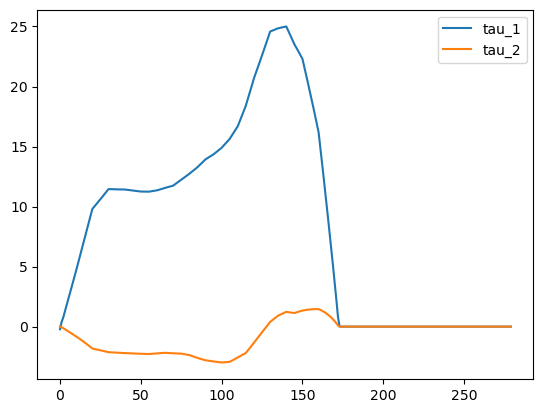

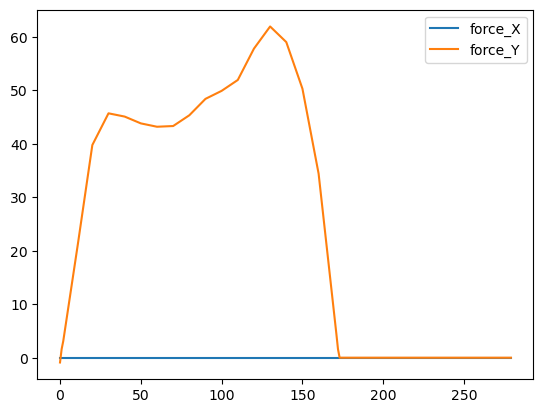

In [380]:
xabi_profile2[["tau_1","tau_2"]].plot()
xabi_profile2[["force_X","force_Y"]].plot()

In [381]:
print(np.max(xabi_profile["tau_1"]))
print(np.max(xabi_profile["tau_2"]))
print(np.max(xabi_profile2["tau_1"]))
print(np.max(xabi_profile2["tau_2"]))

25.0
1.4593777691310843
25.0
1.4593777691310843
